## Imports

In [ ]:

import pandas as pd
import numpy as np
import missingno as msno
import datetime
import matplotlib.pyplot as plt
import httpx
import json
import math
import os

from tqdm import tqdm

import plotly.express as px
import plotly.graph_objects as go

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import sklearn.preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score

from k_means_constrained import KMeansConstrained

import pmdarima as pm

import xgboost as xgb

## Helper functions

In [ ]:
def get_folder_dict(path):
    # get the subfolder directories (year-month)
    dir_list = os.listdir(path)
    dir_list.sort()

    if '.DS_Store' in dir_list:
        dir_list.remove('.DS_Store')

    # create dictionary with files per subfolder
    dir_dict = dict()

    for folder in dir_list:
        dir_dict[folder] = os.listdir(path + '/' + folder)
        
    return dir_dict

In [ ]:
def compiler_by_force(path, force, target_path):
    ''' Exports three csv files with the compiled data for the selected force'''
    # create dictionary with files per subfolder
    dir_dict = get_folder_dict(path)
    
    # create three list of paths for the street, outcomes and stop and search data of the selected force
    force_street_paths = []
    force_outcomes_paths = []
    force_stop_and_search_paths = []
    anomalies_paths = []

    for key in dir_dict:
        for item in dir_dict[key]:
            if force in item:
                if 'street' in item:
                    force_street_paths.append(key + '/' + item)
                elif 'outcomes' in item:
                    force_outcomes_paths.append(key + '/' + item)
                elif 'stop-and-search' in item:
                    force_stop_and_search_paths.append(key + '/' + item)
                else:
                    anomalies_paths.append(key + '/' + item)
    
    # create three dataframes for the street, outcomes and stop and search data of the selected force
    df_force_street = pd.DataFrame()
    df_force_outcomes = pd.DataFrame()
    df_force_stop_and_search = pd.DataFrame()

    for path_extension in force_street_paths:
        df = pd.read_csv(path + '/' + path_extension)
        df_force_street = pd.concat([df_force_street, df])
    print('Compiled ' + str(len(force_street_paths)) + ' number of street files')

    for path_extension in force_outcomes_paths:
        df = pd.read_csv(path + '/' + path_extension)
        df_force_outcomes = pd.concat([df_force_outcomes, df])
    print('Compiled ' + str(len(force_outcomes_paths)) + ' number of outcomes files')

    for path_extension in force_stop_and_search_paths:
        df = pd.read_csv(path + '/' + path_extension)
        df_force_stop_and_search = pd.concat([df_force_stop_and_search, df])
    print('Compiled ' + str(len(force_stop_and_search_paths)) + ' number of stop and search files')
    
    # export the three dataframes to csv    
    df_force_street.to_csv(target_path + '/' + force + '_street.csv')
    df_force_outcomes.to_csv(target_path + '/' + force + '_outcomes.csv')
    df_force_stop_and_search.to_csv(target_path + '/' + force + '_stop_and_search.csv')

In [ ]:
def get_all_force_names(path):
    # create dictionary with files per subfolder
    dir_dict = get_folder_dict(path)
    force_list = []
    for key in dir_dict:
        for item in dir_dict[key]:
            if 'stop-and-search' in item:
                force = '-'.join(item.split('.')[0][8:].split('-')[:-3])
            else:
                force = '-'.join(item.split('.')[0][8:].split('-')[:-1])
            if force not in force_list:
                force_list.append(force)
    return force_list
    

In [ ]:
def compile_all_forces(path, target_path):
    force_list = get_all_force_names(path)
    for force in force_list:
        compiler_by_force(path, force, target_path)
        print('Compiled data for ' + force)

In [ ]:
def load_forces(forces):
    df_streets = dict()
    df_outcomes = dict()
    df_stop_and_search = dict()
    
    for force in forces:
        file_path_streets = './Data/force_data/' + force + '_street.csv'
        file_path_outcomes = './Data/force_data/' + force + '_outcomes.csv'
        file_path_stop_and_search = './Data/force_data/' + force + '_stop_and_search.csv'
        
        df_streets[force] = pd.read_csv(file_path_streets, low_memory=False)
        df_outcomes[force] = pd.read_csv(file_path_outcomes, low_memory=False)
        df_stop_and_search[force] = pd.read_csv(file_path_stop_and_search, low_memory=False)
        
        df_stop_and_search[force]['Datetime'] = pd.to_datetime(df_stop_and_search[force]['Date'])
        df_stop_and_search[force]['Date'] = df_stop_and_search[force]['Datetime'].dt.date
    
    return df_streets, df_outcomes, df_stop_and_search

In [ ]:
def plot_forces_sas(df, forces = []):
    df_dates = dict()
    plt.figure(figsize=(16, 8), dpi=150)
    
    if forces == []:
        for key in df:
            df_dates[key] = df[key]['Date'].value_counts()
            df_dates[key].sort_index(inplace=True)
            df_dates[key].plot(label=key)
    else:
        for force in forces:
            df_dates[force] = df[force]['Date'].value_counts()
            df_dates[force].sort_index(inplace=True)
            df_dates[force].plot(label=force)

    plt.ylabel('Number of stop and searches')
    plt.xlabel('Time')
    plt.legend()

In [ ]:
def combine_csvs_in_dir_to_df(dir_name):
    df = pd.DataFrame()
    for root, directories, files in os.walk(dir_name):
        for file in tqdm(files):
            df = df.append(pd.read_csv(f'{dir_name}/{file}'))
    return df

In [ ]:
def plot_forces_streets(df, forces=[]):
    df_months = dict()
    plt.figure(figsize=(16, 8), dpi=150)
    
    if forces == []:
        for key in df:
            df_months[key] = df[key]['Month'].value_counts()
            df_months[key].sort_index(inplace=True)
            df_months[key].plot(label=key)
    else:
        for force in forces:
            df_months[force] = df[force]['Month'].value_counts()
            df_months[force].sort_index(inplace=True)
            df_months[force].plot(label=force)

    plt.ylabel('Number of incidents')
    plt.xlabel('Months')
    plt.legend()

## Main

### Compiler

In [ ]:
path = './Data/Jan_2010_Oct_2021'
target_path = './Data/force_data'
force = 'city-of-london'
compiler_by_force(path, force, target_path)

In [ ]:
path = './Data/Jan_2010_Oct_2021'
target_path = './Data/force_data'
compile_all_forces(path, target_path)

### EDA

In [ ]:
forces = ['city-of-london', 'metropolitan', 'surrey', 'hertfordshire',
          'thames-valley', 'essex', 'kent', 'hampshire', 'bedfordshire']
df_streets, df_outcomes, df_stop_and_search = load_forces(forces)

In [ ]:
df_streets['city-of-london'].head()

In [ ]:
df_streets['metropolitan'].shape, df_outcomes['metropolitan'].shape, df_stop_and_search['metropolitan'].shape

In [ ]:
msno.matrix(df_streets['city-of-london'])

In [ ]:
plot_forces_streets(df_streets)

In [ ]:
forces = ['city-of-london', 'surrey', 'hertfordshire',
          'thames-valley', 'essex', 'kent', 'hampshire', 'bedfordshire']
plot_forces_streets(df_streets, forces)

In [ ]:
plot_forces_sas(df_stop_and_search)

In [ ]:
forces = ['city-of-london', 'surrey', 'hertfordshire',
          'thames-valley', 'essex', 'kent', 'hampshire', 'bedfordshire']
plot_forces_sas(df_stop_and_search, forces)

In [ ]:
import pandas as pd
import numpy as np
path = 'https://raw.githubusercontent.com/selva86/datasets/master/daily-min-temperatures.csv'
df = pd.read_csv(path, parse_dates=['Date'], index_col='Date')
df

In [ ]:
def df_to_ts(df):
    ts = pd.DataFrame()

    ts = df['Month'].value_counts()
    ts.sort_index(inplace=True)

    return ts

In [ ]:
ts = df_to_ts(df_streets['city-of-london'])
ts

In [ ]:
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller

In [ ]:
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

In [ ]:
def adf_test(ts):    
    statistic, p_value, n_lags, nobs, critical_values, icbest  = adfuller(ts)
    # Format Output
    print(f'ADF Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value > 0.05 else ""}stationary')

In [ ]:
kpss_test(ts)

In [ ]:
adf_test(ts)

In [ ]:
outcomes = pd.read_csv("./Data/city-of-london/city-of-london_outcomes.csv") 
sas = pd.read_csv("./Data/city-of-london/city-of-london_stop_and_search.csv")
street = pd.read_csv("./Data/city-of-london/city-of-london_street.csv")

In [ ]:
street.groupby(['Month', 'Crime type'])['Crime type'].count().unstack().plot(figsize = (15,8))  

In [ ]:
shop = street[street["Crime type"] == "Shoplifting"]
shop.groupby(['Month'])['Crime type'].count().plot()

In [ ]:
vio = street[street["Crime type"] == "Violent crime"]
vio.groupby(['Month'])['Crime type'].count().plot()

In [ ]:
vio = street[street["Crime type"] == "Violence and sexual offences"]
vio.groupby(['Month'])['Crime type'].count().plot()

In [ ]:
weapon = street[street["Crime type"] == "Possession of weapons"]
weapon.groupby(['Month'])['Crime type'].count().plot()

In [ ]:
weapon = street[street["Crime type"] == "Theft from the person"]
weapon.groupby(['Month'])['Crime type'].count().plot()

In [ ]:
drugs = street[street["Crime type"] == "Drugs"]
drugs.groupby(['Month'])['Crime type'].count().plot()

In [ ]:
street.groupby(['Month', 'LSOA name'])['LSOA code'].count().unstack().plot(figsize = (15,8))  

In [ ]:
arrests = pd.Series(street.groupby("Crime type")["Crime type"].count().sort_values(ascending=False))
arrests.plot.bar()

In [ ]:
lsoa = pd.Series(street.groupby("LSOA name")["LSOA name"].count().sort_values(ascending=False))
lsoa.plot.bar(figsize = (30, 5))

In [ ]:
verdicts =pd.Series(outcomes.groupby("Outcome type")["Outcome type"].count().sort_values(ascending=False))
verdicts.plot.bar()

In [ ]:
outcomessas = pd.Series(sas.groupby("Outcome")["Outcome"].count().sort_values(ascending=False))
outcomessas.plot.bar()

### Time series

In [ ]:
forces = ['metropolitan', 'city-of-london', 'kent', 'sussex', 'surrey', 
          'essex', 'hertfordshire', 'thames-valley', 'bedfordshire', 'hampshire']
df_streets = load_forces(forces)

In [ ]:
df_streets_all = pd.DataFrame()

for key in forces:
    df_streets_all = pd.concat([df_streets_all, df_streets[0][key]], ignore_index=True)

In [ ]:
df_streets_all.dtypes

In [ ]:
file_path_employment = './Data/2019_employment.csv'
df_employment = pd.read_csv(file_path_employment, low_memory=False, sep=';')

In [ ]:
df_employment.dtypes

In [ ]:
df_employment[df_employment['LSOA Code (2011)'] == 'E01000027']

In [ ]:
df_employment.columns

In [ ]:
df_employment[['LSOA Code (2011)', 'Local Authority District code (2019)', 'Local Authority District name (2019)', 'Employment Domain Score']]
        

In [ ]:
df_streets_all = df_streets_all.merge(df_employment[['LSOA Code (2011)', 'Local Authority District code (2019)', 'Local Authority District name (2019)', 'Employment Domain Score']]
        , how = 'left', left_on = 'LSOA code', right_on = 'LSOA Code (2011)')

In [ ]:
df_streets_all = df_streets_all.drop(['LSOA Code (2011)'], axis=1)

In [ ]:
file_path_income = './Data/2019_income.csv'
df_income = pd.read_csv(file_path_income, low_memory=False, sep=';')

In [ ]:
df_income.dtypes

In [ ]:
df_income[df_income['LSOA Code (2011)'] == 'E01000027']

In [ ]:
df_income.columns

In [ ]:
df_income[['LSOA Code (2011)', 'Income Domain Score', 'IDACI Score', 'IDAOPI Score']]

In [ ]:
df_streets_all = df_streets_all.merge(df_income[['LSOA Code (2011)', 'Income Domain Score', 'IDACI Score', 'IDAOPI Score']], how = 'left', left_on = 'LSOA code', right_on = 'LSOA Code (2011)')

In [ ]:
df_streets_all = df_streets_all.drop(['LSOA Code (2011)'], axis=1)

In [ ]:
df_streets_all.head()

In [ ]:
file_path_police_strength = './Data/police_strength.csv'
df_police_strength = pd.read_csv(file_path_police_strength, low_memory=False, sep=';')

In [ ]:
df_police_strength.head()

In [ ]:
df_police_strength.dtypes

In [ ]:
df_police_strength.columns

In [ ]:
df_police_strength[['force_name', '2019']]

In [ ]:
df_streets_all['Reported by'].unique()

In [ ]:
force_conv = {'Metropolitan Police':'Metropolitan Police Service', 
              'London, City of':'City of London Police',
              'Kent':'Kent Police', 
              'Hampshire':'Hampshire Constabulary',
              'Avon & Somerset':'Avon and Somerset Constabulary', 
              'Sussex':'Sussex Police', 
              'Surrey':'Surrey Police',
              'Essex':'Essex Police',
              'Hertfordshire':'Hertfordshire Constabulary',
              'Thames Valley':'Thames Valley Police',
              'Bedfordshire':'Bedfordshire Police'}

In [ ]:
df_police_strength['force_name'] = df_police_strength['force_name'].map(force_conv, na_action='ignore')

In [ ]:
df_police_strength[df_police_strength['force_name'] == 'Bedfordshire Police']['2003']

In [ ]:
df_streets_all.head()

In [ ]:
for col in df_police_strength.columns[2:]:
    df_streets_all = df_streets_all.merge(df_police_strength[['force_name', col]], how = 'left', left_on = 'Reported by', right_on = 'force_name')
    df_streets_all = df_streets_all.drop(['force_name'], axis=1)

    

In [ ]:
df_streets_all = df_streets_all.merge(df_police_strength[['force_name', '2019']], how = 'left', left_on = 'Reported by', right_on = 'force_name')


In [ ]:
df_streets_all = df_streets_all.drop(['force_name'], axis=1)


In [ ]:
file_path_police_funding = './Data/police_funding.csv'
df_police_funding = pd.read_csv(file_path_police_funding, low_memory=False, sep=';')

In [ ]:
df_police_funding

In [ ]:
df_police_funding['Police force'] = df_police_funding['Police force'].map(force_conv, na_action='ignore')

In [ ]:
df_streets_all = df_streets_all.merge(df_police_funding[['Police force', '2018-19']], how = 'left', left_on = 'Reported by', right_on = 'Police force')


In [ ]:
df_streets_all.head(5)

In [ ]:
df_streets_all = df_streets_all.drop(['Police force'], axis=1)


In [ ]:
file_path_population = './Data/2018_population_data.csv'
df_population = pd.read_csv(file_path_population, low_memory=False, sep=';')

In [ ]:
df_population

In [ ]:
df_streets_all = df_streets_all.merge(df_population[['CODE', 'POPULATION (2018)']], how = 'left', left_on = 'Local Authority District code (2019)', right_on = 'CODE')


In [ ]:
df_streets_all.head()

In [ ]:
df_streets_all = df_streets_all.drop(['CODE'], axis=1)


In [ ]:
df_streets_all.rename(columns = {'2019':'Police Strength', '2018-19':'Police Funding', 'POPULATION (2018)':'Population'}, inplace = True)


In [ ]:
df_2019 = df_streets_all[df_streets_all['Month'].str.contains('2019')]

In [ ]:
df_2019.to_csv('./Data/2019_data.csv', index=False)

### Choropleth map

In [ ]:
mapbox_access_token = 'pk.eyJ1Ijoia2Npbm5heSIsImEiOiJja3lkMDJhcmUwODJmMm9zMjhob2V1N296In0.ymuiGnyaAIJSFC71UwlZYQ'
px.set_mapbox_access_token(mapbox_access_token)

In [ ]:
# Load different datasets
df_postcodes = pd.read_csv('./Data/2019_postcodes.csv', low_memory=False)
df_postcodes = df_postcodes[df_postcodes['rgn'] == 'E12000007']

LSOAS_all_of_london = list(df_postcodes['lsoa11'].unique())

df_income = pd.read_csv('./Data/2019_income.csv', low_memory=False)
df_income = df_income[df_income["LSOA Code (2011)"].isin(LSOAS_all_of_london)]

df_employment = pd.read_csv('./Data/2019_employment.csv', low_memory=False)
df_employment = df_employment[df_employment["LSOA Code (2011)"].isin(LSOAS_all_of_london)]

df_stop_and_search = pd.read_csv('./Data/2019_city_of_london_stop_and_search.csv').append(pd.read_csv('./Data/2019_metropolitan_stop_and_search.csv'))
df_arrests = df_stop_and_search[df_stop_and_search['Outcome linked to object of search'] == True]

df_searches = df_stop_and_search[df_stop_and_search['Latitude'].notnull()]
df_searches = df_searches[df_searches['Longitude'].notnull()]

df_arrests = df_arrests[df_arrests['Latitude'].notnull()]
df_arrests = df_arrests[df_arrests['Longitude'].notnull()]

In [ ]:
df_metropolitan_street = combine_csvs_in_dir_to_df('multidata/metropolitan/street')
df_metropolitan_street = df_metropolitan_street[df_metropolitan_street["LSOA code"].isin(LSOAS_all_of_london)]

df_cityoflondon_street = combine_csvs_in_dir_to_df('multidata/city-of-london/street')
df_cityoflondon_street = df_cityoflondon_street[df_cityoflondon_street["LSOA code"].isin(LSOAS_all_of_london)]

df_alloflondon_street = df_metropolitan_street.append(df_cityoflondon_street)
df_alloflondon_street = df_alloflondon_street.dropna(axis=0, subset=['Crime type'])

In [ ]:
# Group the data
df_alloflondon_street_counts = df_alloflondon_street.groupby('LSOA code').size().to_frame('size')
df_alloflondon_street_counts.reset_index(level=0, inplace=True)
df_alloflondon_street_counts['log(size)'] = df_alloflondon_street_counts['size'].apply(lambda x: math.log(x))
df_alloflondon_street_counts = df_alloflondon_street_counts.rename(columns={"size": "Crime rate", "log(size)": "Crime rate log"})
df_alloflondon_street_counts.head(5)

In [ ]:
# Load GeoJSON file
GEOJSON_FULL = json.load(open('Data\LSOAS_all_of_london.geojson'))

In [ ]:
# Create Mapbox choropleth map

In [ ]:
fig = px.choropleth_mapbox(
    df_income,
    geojson = GEOJSON_FULL,
    locations = 'LSOA Code (2011)',
    color = 'Income Domain Rank (where 1 is most deprived)',
    color_continuous_scale = "Viridis",
    mapbox_style = "carto-positron",
    zoom = 8.6,
    center = {"lat": 51.49, "lon": -0.12},
    opacity = 0.9
)

fig.update_traces(marker_line_width=0)

fig.show()

In [ ]:
fig = px.choropleth_mapbox(
    df_employment,
    geojson = GEOJSON_FULL,
    locations = 'LSOA Code (2011)',
    color = 'Employment Domain Rank (where 1 is most deprived)',
    color_continuous_scale = "Viridis",
    mapbox_style = "carto-positron",
    zoom = 8.6,
    center = {"lat": 51.49, "lon": -0.12},
    opacity = 0.9
)

fig.update_traces(marker_line_width=0)

fig.show()

In [ ]:
fig = go.Figure(go.Scattermapbox(
        lat=list(df_searches['Latitude']),
        lon=list(df_searches['Longitude']),
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=2,
            opacity=1,
            color="orange"
        ),
        text=list(df_searches['Type']),
        name="Searches"
    ))

fig.add_trace(
    go.Scattermapbox(
        lat=list(df_arrests['Latitude']),
        lon=list(df_arrests['Longitude']),
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=5,
            opacity=1,
            color="blue"
        ),
        text=list(df_arrests['Type']),
        name="Arrests"
    )
)

fig.update_layout(
    hovermode='closest',
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=go.layout.mapbox.Center(
            lat=51.49,
            lon=-0.12
        ),
        pitch=0,
        zoom=8.6
    )
)

fig.show()

In [ ]:
fig = px.choropleth_mapbox(
    df_alloflondon_street_counts,
    geojson = GEOJSON_FULL,
    locations = 'LSOA code',
    color = 'Crime rate',
    color_continuous_scale = "Viridis",
    mapbox_style = "carto-positron",
    zoom = 8.6,
    center = {"lat": 51.49, "lon": -0.12},
    opacity = 0.9
)

fig.update_traces(marker_line_width=0)

fig.show()

In [ ]:
fig = px.choropleth_mapbox(
    df_alloflondon_street_counts,
    geojson = GEOJSON_FULL,
    locations = 'LSOA code',
    color = 'Crime rate log',
    color_continuous_scale = "Viridis",
    mapbox_style = "carto-positron",
    zoom = 8.6,
    center = {"lat": 51.49, "lon": -0.12},
    opacity = 0.9
)

fig.update_traces(marker_line_width=0)

fig.show()

## Models

### K-Nearest Neighbors

In [ ]:
data =  pd.read_csv('.Data/2019_data.csv', encoding='utf-8', decimal=',')
data.shape
prob = data

In [ ]:
#to give insight in the crimes per LSOA in 2019
crimerate = prob.groupby('LSOA code')['Month'].count()
#sum(crimerate.values)
crimerate

In [ ]:
#to get the cluster data for each lsoa once
prob = prob.drop_duplicates(subset="LSOA code", keep='first')

In [ ]:
#remove the nan values
a = prob[prob['Employment Domain Score'].notna()]

In [ ]:
### Get all the features columns except the class
features_lst = ['LSOA code','Employment Domain Score','Income Domain Score','IDACI Score','IDAOPI Score','Police Strength',
                'Police Funding','Population']


### Get the features data
data = a[features_lst].reset_index()

In [ ]:
fit_data = data[['Employment Domain Score', 'Income Domain Score',
       'IDACI Score', 'IDAOPI Score', 'Police Strength', 'Police Funding',
       'Population']]

In [ ]:
#remove the 1.101.360 -> this is not computable to float
fit_data['Population'] = fit_data['Population'].replace(['1.101.360'],'1101.360')

In [ ]:
#replace the nan values with the mode of the column
for column in fit_data.columns:
    fit_data[column].fillna(fit_data[column].mode()[0], inplace=True)

In [ ]:
fit_data

In [ ]:
clf = KMeansConstrained(n_clusters = 50, size_min=250, size_max=800,random_state=0)

In [ ]:
clf.fit(fit_data)

In [ ]:
#make a new dataframe
label_data = pd.DataFrame({'LSOA code': data['LSOA code'], 'Cluster': clf.labels_})
#label_data

In [ ]:
label_data.sort_values(by=['LSOA code'], inplace = True)
label_data['crime numb'] = crimerate.values
label_data.groupby('Cluster')['crime numb'].sum().plot(kind ='bar', ylabel='Number of crimes', 
                                                       title=' Distribution of crimes over the clusters');

In [ ]:
label_data.groupby('Cluster')

In [ ]:
#makes a dataframe for each cluster
df = [x for _, x in label_data.groupby('Cluster')]
numbcrimes = []
for i in df:
    numbcrimes.append(i['crime numb'].sum())

In [ ]:
plt.hist(numbcrimes, bins=23)

In [ ]:
cluster1 = df[2]['LSOA code'].values.tolist()
#cluster1

In [ ]:
df_street = pd.read_csv('./Data/city-of-london/city-of-london_street.csv')
df_street.index = pd.to_datetime(df_street['Month'])
df_notna = df_street[df_street['LSOA code'].notna()]

In [ ]:
df_notna = df_notna[df_notna['LSOA code'].isin(cluster1)]

In [ ]:
data = df_notna.groupby(by=[df_notna.index.date])['Month'].count()
data

### SARIMA

In [ ]:
# split the data into train and testdata and remove the covid data
for t in range(0,len(data.index)):
    if data.index[t] >= datetime.date(2019, 1, 1):
        break
for m in range(t+1, len(data.index)):
    if data.index[m] >= datetime.date(2020,1,1):
        break

data_train = data[:t]
data_test = data[t:m]

In [ ]:
#plot the train test split
sns.lineplot(data=data_train)
sns.lineplot(data=data_test);

In [ ]:
# Seasonal - fit stepwise auto-ARIMA
Sarima = pm.auto_arima(data_train, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

Sarima.summary() 

In [ ]:
n_periods = 12
fitted, confint = Sarima.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(data_train.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(data_train)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA model for LSOA E01000001")
plt.plot(data_test)
plt.legend()
plt.show()

### Decision Tree Model

In [ ]:
# Input the 2019 Dataset
df = pd.read_csv('./Data/2019_data.csv')

In [ ]:
# Display import
df.head(-5)

In [ ]:
# Drop required values that contain NAN
df.dropna(subset=['LSOA code', 'Month', 'Location', 'Crime type', 'Longitude', 'Latitude', 'Employment Domain Score',
       'Income Domain Score', 'IDACI Score', 'IDAOPI Score', 'Police Strength',
       'Police Funding', 'Population'], inplace=True)

In [ ]:
df[df['Month'] == '2019-05']['Crime type'].mode()

In [ ]:
for month in df['Month'].unique():
    print(month)
    print(df[df['Month'] == month]['Crime type'].mode())

In [ ]:
df.columns

In [ ]:
df.replace(to_replace=",", value=".", regex=True, inplace=True)

In [ ]:
df['Population'].isnull().sum()

In [ ]:
df['Police Strength'].isnull().sum()

In [ ]:
df['Population'] = df['Population'].str.replace('.', '').fillna(df['Population']*1000)

In [ ]:
df['Police Strength'] = df['Police Strength'].str.replace('.','')

#### Crime Type Prediction

In [ ]:
# Encode Desired Values to integers to use in models
ohe = LabelEncoder()
df['E LSOA code'] = ohe.fit_transform(df['LSOA code'].dropna().values)
df['E Month'] = ohe.fit_transform(df['Month'].dropna().values)
df['E Location'] = ohe.fit_transform(df['Location'].dropna().values)

In [ ]:
# Create an X and Y
X = df[['E LSOA code', 'E Month', 'E Location', 'Longitude', 'Latitude', 'Employment Domain Score',
       'Income Domain Score', 'IDACI Score', 'IDAOPI Score', 'Police Strength',
       'Police Funding', 'Population']].values
Y = df['Crime type'].values

In [ ]:
# Fit Decision Tree on Crime Types and split the dataset in training and data.
clf = tree.DecisionTreeClassifier(max_depth=10)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)
clf.fit(X_train, y_train)

In [ ]:
# Predictions on Test Set
preds = clf.predict(X_test)

In [ ]:
accuracy_score(y_test, preds)

In [ ]:
# Predictions in a Dataframe
df_preds = pd.DataFrame()
df_preds['y'] = y_test
df_preds['pred'] = preds

In [ ]:
df_preds

In [ ]:
# Accuracy
len(df_preds.loc[df_preds['y'] == df_preds['pred']]) / len(y_test)

In [ ]:
df_preds['y'].value_counts()

In [ ]:
df_preds['pred'].value_counts()

In [ ]:
balanced_accuracy_score(df_preds['y'].values, df_preds['pred'].values)

In [ ]:
accuracies = {}
for crime in df_preds['y'].unique():
    crime_y = df_preds.loc[df_preds['y'] == crime, 'y'].values
    crime_pred = df_preds.loc[df_preds['y'] == crime, 'pred'].values
    acc = round(accuracy_score(crime_y,crime_pred) * 100,2)
    accuracies[crime] = acc
#     print('Accuracy for {} is {}%'.format(crime,acc))
df_crimes = pd.DataFrame.from_dict(accuracies, orient='index').sort_values(0, ascending=False)
df_crimes

In [ ]:
counts = {}
for crime in df_preds['y'].unique():
    c = round((len(df_preds[df_preds['y'] == crime]) / len(df_preds)) *100,2)
    counts[crime] = c
df_crimes['Relativity'] = df_crimes.index.map(counts)
df_crimes

In [ ]:
#df_preds['y'].value_counts().plot(kind='barh')
x = [str(x) for x in df_preds['y'].value_counts().sort_index().index.values]
y = df_preds['y'].value_counts().sort_index().values
y2 = [len(df_preds[df_preds['pred'] == crime]) for crime in x]
len(x), len(y), len(y2)

In [ ]:
labels = x
men_means = y
women_means = y2

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, men_means, width, label='Men')
rects2 = ax.bar(x + width/2, women_means, width, label='Women')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticklabels(x)
ax.legend()

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

In [ ]:
# Plot the Decision Tree
tree.plot_tree(clf);

### Experimental

#### Random Forest

In [ ]:
# Input the 2019 Dataset
df = pd.read_csv('2019_data.csv')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3296: DtypeWarning: Columns (20) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
# Drop required values that contain NAN
df.dropna(subset=['LSOA code', 'Month', 'Location', 'Crime type', 'Longitude', 'Latitude', 'Employment Domain Score',
       'Income Domain Score', 'IDACI Score', 'IDAOPI Score', 'Police Strength',
       'Police Funding', 'Population'], inplace=True)

In [ ]:
df.replace(to_replace=",", value=".", regex=True, inplace=True)

In [ ]:
df['Population'] = df['Population'].str.replace('.', '').fillna(df['Population']*1000)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """Entry point for launching an IPython kernel.


In [ ]:
df['Police Strength'] = df['Police Strength'].str.replace('.','')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """Entry point for launching an IPython kernel.


##### Crime Type Prediction

In [ ]:
# Encode Desired Values to integers to use in models
ohe = LabelEncoder()
df['E LSOA code'] = ohe.fit_transform(df['LSOA code'].dropna().values)
df['E Month'] = ohe.fit_transform(df['Month'].dropna().values)
df['E Location'] = ohe.fit_transform(df['Location'].dropna().values)

In [ ]:
# Create an X and Y
X = df[['E LSOA code', 'E Month', 'E Location', 'Longitude', 'Latitude', 'Employment Domain Score',
       'Income Domain Score', 'IDACI Score', 'IDAOPI Score', 'Police Strength',
       'Police Funding', 'Population']].values
Y = df['Crime type'].values

In [ ]:
# Fit Decision Tree on Crime Types and split the dataset in training and data.
clf = RandomForestClassifier()
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
# Predictions on Test Set
preds = clf.predict(X_test)

In [ ]:
accuracy_score(y_test, preds)

0.3385904001388768

In [ ]:
# Predictions in a Dataframe
df_preds = pd.DataFrame()
df_preds['y'] = y_test
df_preds['pred'] = preds

In [ ]:
df_preds

,y,pred
0,Shoplifting,Other theft
1,Robbery,Violence and sexual offences
2,Violence and sexual offences,Burglary
3,Anti-social behaviour,Anti-social behaviour
4,Criminal damage and arson,Public order
...,...,...
230415,Bicycle theft,Other theft
230416,Violence and sexual offences,Public order
230417,Violence and sexual offences,Public order
230418,Shoplifting,Shoplifting


In [ ]:
# Accuracy
len(df_preds.loc[df_preds['y'] == df_preds['pred']]) / len(y_test)

0.3385904001388768

In [ ]:
df_preds['y'].value_counts()

Violence and sexual offences    60988
Anti-social behaviour           44148
Other theft                     21663
Vehicle crime                   20596
Criminal damage and arson       16644
Burglary                        14666
Public order                    13233
Shoplifting                     11483
Drugs                            7277
Theft from the person            6284
Robbery                          4845
Bicycle theft                    3736
Other crime                      3243
Possession of weapons            1614
Name: y, dtype: int64

In [ ]:
df_preds['pred'].value_counts()

Violence and sexual offences    71117
Anti-social behaviour           48901
Other theft                     20888
Vehicle crime                   18597
Shoplifting                     14226
Criminal damage and arson       13374
Burglary                        12279
Public order                    10100
Drugs                            5924
Theft from the person            5590
Robbery                          3417
Bicycle theft                    2727
Other crime                      2243
Possession of weapons            1037
Name: pred, dtype: int64

#### XG Boost

In [ ]:
df = pd.read_csv('2019_data.csv')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3296: DtypeWarning: Columns (20) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
df.dropna(subset=['LSOA code', 'Month', 'Location', 'Crime type', 'Longitude', 'Latitude', 'Employment Domain Score',
       'Income Domain Score', 'IDACI Score', 'IDAOPI Score', 'Police Strength',
       'Police Funding', 'Population'], inplace=True)

In [ ]:
df.sort_values(by="Month")

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,...,Context,Local Authority District code (2019),Local Authority District name (2019),Employment Domain Score,Income Domain Score,IDACI Score,IDAOPI Score,Police Strength,Police Funding,Population
0,a8977a2a4e14252420371eb993d52e4d0b8288a7c833e6...,2019-01,Metropolitan Police Service,Metropolitan Police Service,-0.709911,50.784615,On or near Rochester Way,E01031384,Arun 018E,Violence and sexual offences,...,NaN,E07000224,Arun,"0,054","0,058","0,055","0,069","30,435",2572,154.414
1918269,d2ba517802ba07206d2576d630670e6a3e1e3b0cd6b982...,2019-01,Thames Valley Police,Thames Valley Police,-0.819947,51.821437,On or near Petrol Station,E01017666,Aylesbury Vale 013B,Other theft,...,NaN,E07000004,Aylesbury Vale,"0,118","0,122","0,163","0,130","4,149",391,184.56
1918268,d0b394692595f3b9c0465d375bde587cd3c148d6b5cf76...,2019-01,Thames Valley Police,Thames Valley Police,-0.815980,51.821657,On or near Sycamore Court,E01017666,Aylesbury Vale 013B,Drugs,...,NaN,E07000004,Aylesbury Vale,"0,118","0,122","0,163","0,130","4,149",391,184.56
1918267,3457b44e2bf5bcdfe766828a39499a8453434408bc4b8f...,2019-01,Thames Valley Police,Thames Valley Police,-0.819717,51.818575,On or near Palmer Avenue,E01017666,Aylesbury Vale 013B,Drugs,...,NaN,E07000004,Aylesbury Vale,"0,118","0,122","0,163","0,130","4,149",391,184.56
1918266,e053c47ce6a7986c9bc1e7a703302f4066df0e3a831491...,2019-01,Thames Valley Police,Thames Valley Police,-0.820359,51.818464,On or near Goodwin Road,E01017666,Aylesbury Vale 013B,Criminal damage and arson,...,NaN,E07000004,Aylesbury Vale,"0,118","0,122","0,163","0,130","4,149",391,184.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1490270,0a26a2ee8ff9bf37dc5964d4093c2e778a557f52720049...,2019-12,Sussex Police,Sussex Police,0.556008,50.868793,On or near Petrol Station,E01021011,Hastings 006B,Burglary,...,NaN,E07000062,Hastings,"0,114","0,121","0,126","0,133","2,629",266,91.093
1490269,NaN,2019-12,Sussex Police,Sussex Police,0.556201,50.867907,On or near Supermarket,E01021011,Hastings 006B,Anti-social behaviour,...,NaN,E07000062,Hastings,"0,114","0,121","0,126","0,133","2,629",266,91.093
1490268,NaN,2019-12,Sussex Police,Sussex Police,0.556238,50.868059,On or near Supermarket,E01021011,Hastings 006B,Anti-social behaviour,...,NaN,E07000062,Hastings,"0,114","0,121","0,126","0,133","2,629",266,91.093
1490166,d4951358c3ac5f06633be0365820042219031968d3c5ae...,2019-12,Sussex Police,Sussex Police,0.599861,50.875244,On or near The Cheviots,E01020972,Hastings 005A,Robbery,...,NaN,E07000062,Hastings,"0,377","0,483","0,575","0,405","2,629",266,91.093


In [ ]:
df.columns

Index(['Crime ID', 'Month', 'Reported by', 'Falls within', 'Longitude',
       'Latitude', 'Location', 'LSOA code', 'LSOA name', 'Crime type',
       'Last outcome category', 'Context',
       'Local Authority District code (2019)',
       'Local Authority District name (2019)', 'Employment Domain Score',
       'Income Domain Score', 'IDACI Score', 'IDAOPI Score', 'Police Strength',
       'Police Funding', 'Population'],
      dtype='object')

In [ ]:
#convert from british ',' to america '.'

df['Employment Domain Score']  =  df['Employment Domain Score'].str.replace('[A-Za-z]', '').str.replace(',', '.').astype(float)
df['Income Domain Score'] = df['Income Domain Score'].str.replace('[A-Za-z]', '').str.replace(',', '.').astype(float)
df['IDACI Score'] = df['IDACI Score'].str.replace('[A-Za-z]', '').str.replace(',', '.').astype(float)
df['IDAOPI Score'] = df['IDAOPI Score'].str.replace('[A-Za-z]', '').str.replace(',', '.').astype(float)
df['Police Strength'] = df['Police Strength'].str.replace('[A-Za-z]', '').str.replace(',', '.').astype(float)




C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys


In [ ]:
df.dtypes

Crime ID                                 object
Month                                    object
Reported by                              object
Falls within                             object
Longitude                               float64
Latitude                                float64
Location                                 object
LSOA code                                object
LSOA name                                object
Crime type                               object
Last outcome category                    object
Context                                 float64
Local Authority District code (2019)     object
Local Authority District name (2019)     object
Employment Domain Score                 float64
Income Domain Score                     float64
IDACI Score                             float64
IDAOPI Score                            float64
Police Strength                         float64
Police Funding                            int64
Population                              

In [ ]:
df["Population"] = df["Population"].astype(str)

In [ ]:
df['Population'] = df['Population'].str.replace('[A-Za-z]', '').str.replace('.', '').astype(float)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """Entry point for launching an IPython kernel.


In [ ]:
data = df.groupby('Reported by').agg({'Crime type':'count', 'Employment Domain Score':'mean', 'Income Domain Score':'mean',  'IDACI Score':'mean', 'IDAOPI Score':'mean', 'Police Strength':'mean', 'Income Domain Score':'mean', 'Police Funding':'mean', 'Population':'mean' })

In [ ]:
data.reset_index()

,Reported by,Crime type,Employment Domain Score,Income Domain Score,IDACI Score,IDAOPI Score,Police Strength,Police Funding,Population
0,Bedfordshire Police,67173,0.096148,0.137558,0.185515,0.196654,1.164,105.0,217518.205723
1,City of London Police,9356,0.026116,0.034127,0.033715,0.064954,739.000,57.0,17732.041257
2,Essex Police,209023,0.109429,0.145892,0.197408,0.166158,3.071,277.0,127734.816293
3,Hampshire Constabulary,163393,0.093014,0.126249,0.169952,0.173650,2.697,315.0,104826.377219
4,Hertfordshire Constabulary,112417,0.076297,0.101921,0.133432,0.135721,2.009,189.0,118639.144889
5,Kent Police,217910,0.117279,0.151934,0.197871,0.172519,3.553,290.0,145697.835712
6,Metropolitan Police Service,1094858,0.092986,0.146387,0.193441,0.261791,30.435,2572.0,240788.935032
7,Surrey Police,97550,0.056062,0.072523,0.096727,0.098313,1.882,218.0,104491.495161
8,Sussex Police,155882,0.104776,0.132460,0.175859,0.170239,2.629,266.0,150414.240105
9,Thames Valley Police,176634,0.070901,0.098579,0.124542,0.150247,4.149,391.0,144207.623227


In [ ]:
X, y = data.iloc[:,0:],data.iloc[:,0]

In [ ]:
X, y = data.iloc[:,:-1],data.iloc[:,-1]

In [ ]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)

In [ ]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)

[00:07:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 91516.171710


##### K-Fold cross validation


In [ ]:
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 10, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

[00:07:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[00:07:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[00:07:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,136935.419271,10996.229659,134026.901042,29637.888024
1,126379.541667,10104.908286,124909.544271,29690.705762
2,116822.812500,9319.945015,116944.015625,29554.948907
3,108185.229167,8631.260504,108813.658854,28721.846882
4,100383.440104,8017.359751,101502.977865,28497.132040


In [ ]:
print((cv_results["test-rmse-mean"]).tail(1))

22    68591.559896
Name: test-rmse-mean, dtype: float64


In [ ]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

[00:07:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
import matplotlib.pyplot as plt

xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [50, 10]
plt.show()

<Figure size 640x480 with 1 Axes>

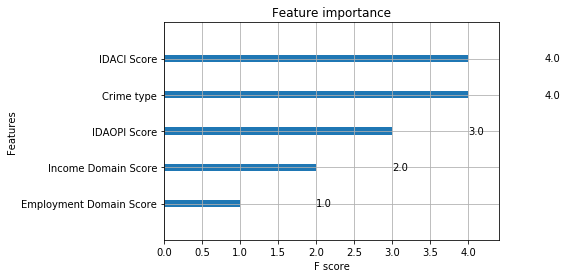

In [ ]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.savefig("feature_importance.png")
plt.show()
